# **Homework 4**
### *Topics in Data Science*
#### Josh Winnes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
import shapely
import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering
from skmob.preprocessing import compression



pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

In [2]:
"""
    sorting the event data frame by user ID and then by time is the most critical step.
"""
os.chdir('/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data')
events = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_", regex=True)
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       'individual_local_identifier', 'individual_taxon_canonical_name']
tortoise.drop(columns=tortoise.columns.difference(cols), inplace=True)

tortoise.insert(loc = 2, column = "timestamp_UTC",
                value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
                )
tortoise.insert(loc = 3, column = "timestamp_local", 
                value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
                )
tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)
tortoise.insert(loc = 4, column = "minute_diff", 
                value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
                    .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
                    )
tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date
tortoise["month_since2009"] = (tortoise.year - tortoise.year.min())*12 + tortoise.month
tortoise["day_since_min"] = (tortoise["timestamp_local"] - tortoise.timestamp_local.min()).apply(lambda x: x.days)
tortoise.reset_index(drop=True, inplace=True)

In [3]:
tortoise_gdf = gpd.GeoDataFrame(tortoise)
tortoise_gdf["geometry"] = gpd.points_from_xy(tortoise_gdf.location_long, tortoise_gdf.location_lat)
tortoise_trajectory = skmob.TrajDataFrame(tortoise, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)

In [4]:
tortoise_jl = jump_lengths(tortoise_trajectory)
tortoise_jl["jump_lengths"] = \
    tortoise_jl["jump_lengths"].apply(
        lambda x: np.append(x,np.nan).tolist())
tortoise_jl = tortoise_jl.explode(["jump_lengths"],
                ignore_index=True).reset_index(drop=True)
tortoise["jump_length"] = tortoise_jl.jump_lengths
tortoise_trajectory["jump_length"] = tortoise_jl["jump_lengths"]

100%|██████████| 96/96 [00:06<00:00, 15.62it/s]


In [5]:
import osmnx as ox
place_name = "Galapagos, Ecuador" #Isla Santa Cruz, Galapagos, Ecuador
santa_cruz_gdf = ox.geocode_to_gdf(place_name)
tessellation = tilers.tiler.get("h3_tessellation", base_shape=santa_cruz_gdf,meters =200)
tessellation["tile_lng"] = tessellation.geometry.centroid.x
tessellation["tile_lat"] = tessellation.geometry.centroid.y

In [6]:
tortoise_trajectory_mapping = tortoise_trajectory.mapping(tessellation,remove_na =True) # map trajectory into tessellation tiles
tortoise_tiled = tortoise_trajectory_mapping.merge(tessellation, on = "tile_ID", how = "inner") # join to get the tile coordinates
tortoise_tiled.drop(columns =["lat","lng"], inplace=True) # drop the original lat/lng so that we can create new trajectory
tortoise_tiled.sort_values(by = ["uid", "datetime"], inplace=True) # sort before making trajectory
tortoise_tiled_trajectory = skmob.TrajDataFrame(tortoise_tiled, latitude='tile_lat', longitude='tile_lng', \
    user_id='uid', datetime='datetime', \
)
tortoise_trajectory_compressed = compression.compress(tortoise_trajectory, spatial_radius_km=0.02) # compressed trajectory
tortoise_tiled_trajectory_compressed = compression.compress(tortoise_tiled_trajectory, spatial_radius_km=0.02) # compressed trajectory
tortoise_stay_location = detection.stay_locations(tortoise_trajectory, 
    stop_radius_factor=0.02, minutes_for_a_stop=400, spatial_radius_km=0.2, leaving_time=True)

In [7]:
color_list = ['#883399','#66c066', '#ff800c','#60ff78','#301e4b'] # purple, green, orange, lime, dark purple
color_list.extend(list(sns.color_palette('tab10').as_hex()))
color_list = color_list * 3 # extend the list by repeating 3 times

month_date_str = '05-01' # adjust this date for analysis needs
start_year = 2010
end_year = 2019
year_list = range(start_year, end_year)
s_date = []
for i in range(start_year, end_year+1):
    s_date.append(pd.Timestamp(str(i)+'-' +month_date_str).tz_localize(tz = 'US/Pacific'))
e_date = s_date[1:]
s_date.pop()

Timestamp('2019-05-01 00:00:00-0700', tz='US/Pacific')

download the spatial-temporal dataset, read into notebook and prepare the data frame, make sure to include columns of: timestamp, latitude, longitude, tortoise ID, and other information

one simple method to detect migration might be through distance of movement: suppose you select day as the unit of time, if you can compute movement scale for each unit, the days with larger scale of movement are the days of migration

you can use radius of gyration, or total trajectory length, to measure scale of movement

you can implement haversine function, or use existing library functions

you can design your other ways of migration detection and implement them, for instance, you may want to investigate using the speed and heading in the dataset

run your migration detection on following tortoises:
Alison, Marilyn, Kitty, Connor, Helber, Christian, Steve Devine

for each tortoise conclude on which dates did the tortoise start the migration, and on which dates did they end the migration


## Alison

In [8]:
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
alison_gdf = tortoise_gdf[tortoise_gdf["individual_local_identifier"] == "Alison"]
alison_trajectory = tortoise_trajectory.query("uid == 'Alison'")
alison_trajectory_mapping = tortoise_trajectory_mapping.query("uid == 'Alison'")
alison_tiled_trajectory = tortoise_tiled_trajectory.query("uid == 'Alison'")
alison_trajectory_compressed = tortoise_trajectory_compressed.query("uid == 'Alison'")
alison_tiled_trajectory_compressed = tortoise_tiled_trajectory_compressed.query("uid == 'Alison'")
alison_stay_location = tortoise_stay_location.query("uid == 'Alison'")

In [9]:
alison_tiled_trajectory['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int32)

In [10]:
alison_plot = alison_trajectory.query("year == 2012").plot_trajectory(zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#883399')
alison_trajectory.query("year == 2013").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#66c066')
alison_trajectory.query("year == 2014").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#ff800c')
alison_trajectory.query("year == 2015").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#60ff78')
alison_trajectory.query("year == 2016").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#301e4b')
alison_trajectory.query("year == 2017").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#301e4b')
alison_trajectory.query("year == 2018").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#301e4b')

alison_plot

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

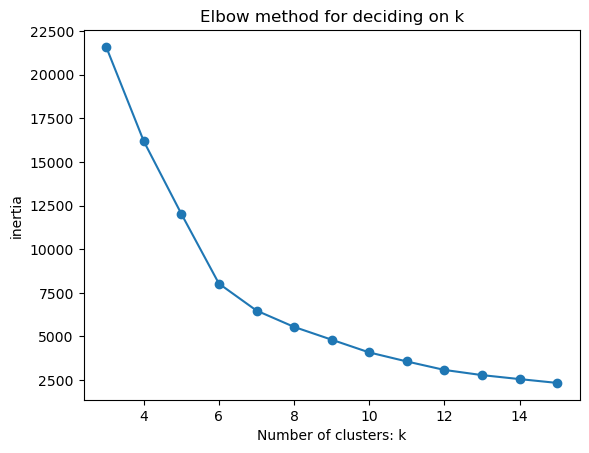

In [12]:
df = alison
colnames = ["location_long", "location_lat","day_since_min"]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

In [13]:
k = 7
colnames = ["location_long", "location_lat","year"]
alison_kmeans = run_kmeans(alison, colnames,k,)
alison_kmeans.groupby("cluster").size()

cluster
0     9304
1     3693
2     8339
3     2393
4    10962
5     3915
6     1397
dtype: int64

<Axes: xlabel='location_lat', ylabel='location_long'>

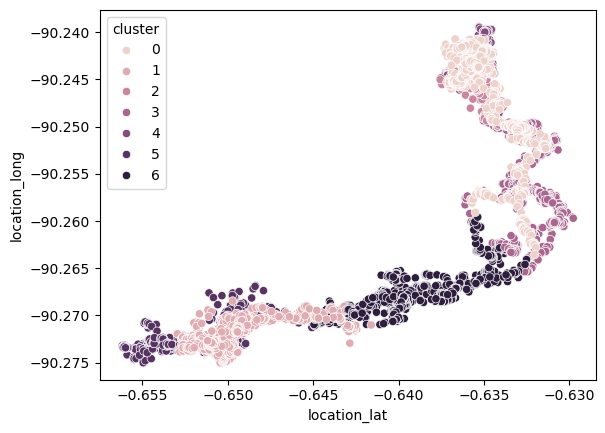

In [14]:
sns.scatterplot(alison_kmeans, x="location_lat", y="location_long", hue="cluster")